<a href="https://colab.research.google.com/github/MoritaHiroki87/ZZ_MachineLearningNote/blob/master/Chainer%E3%81%AE%E5%BF%9C%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 15 Chainerの応用

In [0]:
from sklearn.datasets import load_iris

x, t = load_iris(return_X_y=True)
x = x.astype('float32')
t = t.astype('int32')

# 15.1 step1: データセットの準備
## 15.1.1 TupleDataset
入力と目標値を与えるとペアにした状態で返してくれるのがTupleDataset。便利。   
以前は訓練の中でインデックスから引っ張ってきてた。

元はこんな感じ。

``` python
        index = order[i:i+n_batchsize]
        x_train_batch = x_train[index,:]
        t_train_batch = t_train[index]
```


In [0]:
from chainer.datasets import TupleDataset

dataset = TupleDataset(x, t)

In [0]:
dataset[0]

(array([5.1, 3.5, 1.4, 0.2], dtype=float32), 0)

In [0]:
dataset[:2]

[(array([5.1, 3.5, 1.4, 0.2], dtype=float32), 0),
 (array([4.9, 3. , 1.4, 0.2], dtype=float32), 0)]

In [0]:
dataset[:10:2]

[(array([5.1, 3.5, 1.4, 0.2], dtype=float32), 0),
 (array([4.7, 3.2, 1.3, 0.2], dtype=float32), 0),
 (array([5. , 3.6, 1.4, 0.2], dtype=float32), 0),
 (array([4.6, 3.4, 1.4, 0.3], dtype=float32), 0),
 (array([4.4, 2.9, 1.4, 0.2], dtype=float32), 0)]

## 15.1.2 データセットの分割
基礎編で訓練用、検証用、テスト用に分割してたけど、そういうのもChainerにある。   
上で作ったTupleDatasetが元になっていることが前提で、入出力がばらけてないからその分少し楽。

元のやり方は下記。
```
# データセットを分割するモジュールの読み込み
from sklearn.model_selection import train_test_split

# テスト用の分割
x_train_val, x_test, t_train_val, t_test = train_test_split(x, t, test_size=0.3, random_state=0)

# 訓練と検証の分割
x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)
```

In [0]:
from chainer.datasets import split_dataset_random

train_val, test = split_dataset_random(dataset, int(len(dataset) * 0.7), seed=0)
train, valid = split_dataset_random(train_val, int(len(train_val) * 0.7), seed=0)

## 15.1.3 SerialIterator
エポックシャッフルを上手いことしてくれる。（とは？）
#### ・エポックシャッフル
→

以前は下記のような流れで実施していた。

```
# わからん

```

In [0]:
from chainer.iterators import SerialIterator

train_iter = SerialIterator(train, batch_size=4, repeat=True, shuffle=True)

minibatch = train_iter.next()

minibatch

[(array([6.3, 3.3, 4.7, 1.6], dtype=float32), 1),
 (array([6.3, 2.5, 5. , 1.9], dtype=float32), 2),
 (array([5.5, 4.2, 1.4, 0.2], dtype=float32), 0),
 (array([7.7, 3. , 6.1, 2.3], dtype=float32), 2)]

# 15.2 step2 ネットワークを決める
## 15.2.1 Chain
以前のやり方では、ネットワークをリンク（層）とファンクション（活性化関数）に分けて、それぞれChainerがいろんな層と活性化関数持ってるからそれ引き込んで、Sequentialで層をデザインしてた。かつなんか層の意味が俺には若干よく分かんなかった。入力次元数ってなんだ？　あるノードに入る入力の次元のことか？　それって前のノードの出力と同じ数じゃないのか？　特に全結合層なら。

まあとにかく以下のような具合に書いていた。

```
from chainer import Sequential

# net としてインスタンス化
n_input = 4
n_hidden = 10
n_output = 3

net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)
```

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F


class Net(chainer.Chain):
    
    def __init__(self, n_in=4, n_hidden=3, n_out=3):
        super().__init__()
        # これ何？ なんかわからんがこのinit_scope内に書いた層に関してオプティマイザで更新かかるっぽい。
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_hidden)
            self.l2 = L.Linear(n_hidden, n_hidden)
            self.l3 = L.Linear(n_hidden, n_out)
    
    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        return h
    
    
net = Net()

In [0]:
net = Net(n_hidden=100)

# 15.3 step3: 目的関数を決める
目的関数っていうと、損失関数のことか。出力値に対してソフトマックスとかかけてあげた結果のやつか。   
ここでchainerチュートリアルのテキストでは正規化項などの非常に難しいことを言い出していて、まあよくわからんのだ。わかるけどピンとこんのだ。
というか重みの更新のことを言い出していて、それって最適化手法の話では...？　と思う。

まあそれらはいいとして、Chainerではパラメータの更新時に更新計算をカスタマイズする方法を二種類提供しているとのこと。
ひとつ目はバイアスを含むパラメータ全てに対して処理を行うオプティマイザフックという機能。
ふたつ目は個々のパラメータに対して処理を行うもので、ネットワークのパラメータが持っているUpdateRuleというオブジェクトにフック関数を追加する。（？）



In [0]:
from chainer import optimizers
from chainer.optimizer_hooks import WeightDecay

optimizer = optimizers.SGD(lr=0.001) # 学習率を0.01に設定
optimizer.setup(net)

for param in net.params():
    if param.name != 'b': # バイアス以外なら
        param.update_rule.add_hook(WeightDecay(0.0001)) # 重み減衰を適用
    

# 15.4 step4: 最適化手法を選択する
最適化手法もたくさんあるから今回はmomentumSGDを使おうとのこと。

In [0]:
from chainer import optimizers
from chainer.optimizer_hooks import WeightDecay

optimizer = optimizers.MomentumSGD(lr=0.001, momentum=0.9)
optimizer.setup(net)

for param in net.params():
    if param.name != 'b':
        param.update_rule.add_hook(WeightDecay(0.0001))

# 15.5 step5: ネットワークを訓練する
GPUを使って訓練するぞ！ corabolatoryだからできる。

注意するのは下記2点
・ネットワークを``to_gpu()``を使ってGPUメモリ上に転送しておく
・ネットワーク上に入力するデータをCuPyのndarrayに変換しておく


In [0]:
gpu_id = 0
n_batch = 64
n_epoch = 50

# ネットワークをGPUメモリ上に転送
net.to_gpu(gpu_id)

# ログ
results_train, results_valid = {}, {}
results_train['loss'], results_train['accuracy'] = [], []
results_valid['loss'], results_valid['accuracy'] = [], []
# results_train
# --> {'accuracy': [], 'loss': []}

train_iter.reset() # 前の章とかで一度next()が呼ばれているため

count = 1

for epoch in range(n_epoch):
    
    while True:
        
        # ミニバッチの取得
        train_batch = train_iter.next()
        
        # xとtに分割
        # データをGPUに転送するために、concat_examplesにgpu_idを渡す
        x_train, t_train = chainer.dataset.concat_examples(train_batch, gpu_id)
        
        # 予測値と目的関数の計算
        y_train = net(x_train)
        loss_train = F.softmax_cross_entropy(y_train, t_train)
        acc_train = F.accuracy(y_train, t_train)
        
        # 勾配の初期化と勾配の計算
        net.cleargrads()
        loss_train.backward()
        
        # パラメータの更新
        optimizer.update()
        
        # カウントアップ
        count += 1
        
        # 1エポック終えたら、validデータで評価する
        if train_iter.is_new_epoch:
            
            # 検証用データに対する結果の確認
            with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
                
                # ここ、validがない。split_dataset_random を使ってvalidを作らないとだめ。
                x_valid, t_valid = chainer.dataset.concat_examples(valid, gpu_id)
                y_valid = net(x_valid)
                loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
                acc_valid = F.accuracy(y_valid, t_valid)
                
            # 注意：GPUで計算した結果はGPU上に存在するため、CUP上に転送します
            loss_train.to_cpu()
            loss_valid.to_cpu()
            acc_train.to_cpu()
            acc_valid.to_cpu()
            
            # 結果の表示
            print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'
                  'acc (train): {:.4f}, acc (valid): {:.4f}'.format(
                epoch, count, loss_train.array.mean(), loss_valid.array.mean(),
                  acc_train.array.mean(), acc_valid.array.mean()))

            # 可視化用に保存
            results_train['loss'] .append(loss_train.array)
            results_train['accuracy'] .append(acc_train.array)
            results_valid['loss'].append(loss_valid.array)
            results_valid['accuracy'].append(acc_valid.array)

            break

epoch: 0, iteration: 20, loss (train): 1.1293, loss (valid): 1.1982acc (train): 0.7500, acc (valid): 0.6562
epoch: 1, iteration: 38, loss (train): 0.5148, loss (valid): 0.4088acc (train): 1.0000, acc (valid): 0.9688
epoch: 2, iteration: 56, loss (train): 0.9593, loss (valid): 0.3514acc (train): 0.2500, acc (valid): 0.9062
epoch: 3, iteration: 74, loss (train): 0.2632, loss (valid): 0.3085acc (train): 1.0000, acc (valid): 0.9688
epoch: 4, iteration: 93, loss (train): 0.4693, loss (valid): 0.3274acc (train): 0.5000, acc (valid): 0.8438
epoch: 5, iteration: 111, loss (train): 0.3065, loss (valid): 0.2545acc (train): 1.0000, acc (valid): 0.9688
epoch: 6, iteration: 129, loss (train): 0.3735, loss (valid): 0.2429acc (train): 1.0000, acc (valid): 0.9688
epoch: 7, iteration: 147, loss (train): 0.2200, loss (valid): 0.2374acc (train): 1.0000, acc (valid): 0.9375
epoch: 8, iteration: 166, loss (train): 0.0609, loss (valid): 0.3217acc (train): 1.0000, acc (valid): 0.8438
epoch: 9, iteration: 184

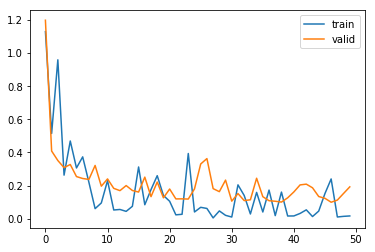

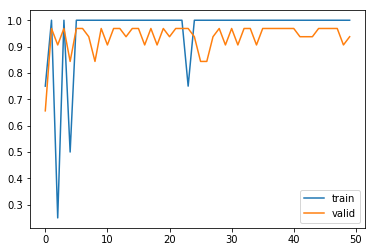

In [0]:
import matplotlib.pyplot as plt

# 損失 (loss)
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示
plt.show()

# 精度 (accuracy)
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示
plt.show()

In [0]:
# テストデータに対する損失と精度を計算
x_test, t_test = chainer.dataset.concat_examples(test, device=gpu_id)
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = net(x_test)
    loss_test = F.softmax_cross_entropy(y_test, t_test)
    acc_test = F.accuracy(y_test, t_test)

print('test loss: {:.4f}'.format(loss_test.array.get()))
print('test accuracy: {:.4f}'.format(acc_test.array.get()))

test loss: 0.1356
test accuracy: 0.9333


In [0]:
from chainer.serializers import save_npz

net.to_cpu()

save_npz('net.npz', net)

In [0]:
import numpy as np

params = np.load('net.npz')

for key, param in params.items():
    print(key, ':\t', param.shape)

l2/b :	 (100,)
l2/W :	 (100, 100)
l3/b :	 (3,)
l3/W :	 (3, 100)
l1/b :	 (100,)
l1/W :	 (100, 4)


ここ最初は隠れ層のノードを3つにしてて、ぜんっぜん学習できてなかった。やっぱ隠れ層いじるとうまくいくんだな。